In [1]:
from fastai.vision.all import *
import fastai
import timm
import pandas as pd

In [2]:
import torch
torch.cuda.set_device(0)

In [3]:
df = pd.read_csv('../dataset.csv')

In [4]:
df = df.drop(df[df.masa<0].index)

In [5]:
dftrain = df[(df.split=='train') | (df.split=='valid')]
dftest = df[(df.split=='test')]

In [6]:
# !mkdir ../datasetClean/train
# !mkdir ../datasetClean/test

In [7]:
# import shutil
# from imutils import paths

In [8]:
# for image in dftrain.image_id.values:
#     shutil.move(image.replace('datasetClean','../datasetClean'),
#                 image.replace('datasetClean','../datasetClean/train'))

In [9]:
# for image in dftest.image_id.values:
#     shutil.move(image.replace('datasetClean','../datasetClean'),
#                 image.replace('datasetClean','../datasetClean/test'))

In [10]:
# df.volumen.describe()

In [11]:
def get_masa(f):
    return float(df[df['image_id']=='datasetClean/'+f.name]['masa'])

def get_volumen(f):
    return float(df[df['image_id']=='datasetClean/'+f.name]['volumen'])

def is_valid(f):
    return (df[df['image_id']=='datasetClean/'+f.name]['split']).values[0]=='valid'

In [12]:
def getDataBlock(presize=512,size=512):
    return DataBlock(blocks = (ImageBlock, RegressionBlock()),
                 get_items=get_image_files, 
                 splitter=FuncSplitter(is_valid),
                 get_y=get_volumen,
                 item_tfms = Resize(presize),
                 batch_tfms=[*aug_transforms(size=size,flip_vert=True,
                                            max_zoom=1.0), Normalize.from_stats(*imagenet_stats)])

In [13]:
path = Path('../datasetClean/')
trainPath = path/'train'

In [14]:
db = getDataBlock()
dls = db.dataloaders(trainPath,bs=8)

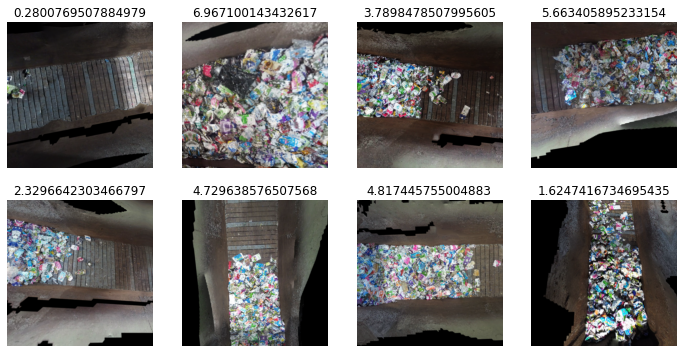

In [15]:
dls.show_batch()

In [16]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    #EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='convnext_base_Volumen')
]

In [17]:
from fastai.metrics import mae

In [18]:
learn = Learner(dls, timm.create_model('convnext_base',num_classes=1,pretrained=True),
                loss_func=MSELossFlat(), metrics=mae,cbs=callbacks).to_fp16()

In [19]:
# learn.lr_find()

epoch,train_loss,valid_loss,mae,time
0,7.195220,1.201769,0.843937,00:19


Better model found at epoch 0 with valid_loss value: 1.2017691135406494.


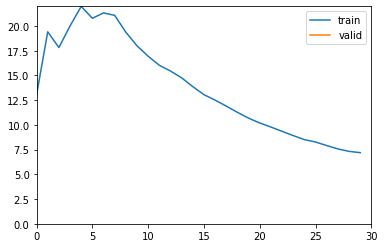

epoch,train_loss,valid_loss,mae,time
0,1.261505,0.552640,0.567036,00:19
1,1.171404,0.732977,0.644339,00:19
2,1.078659,0.510368,0.580727,00:19
3,1.038202,0.578044,0.584532,00:19
4,0.928018,0.533169,0.557073,00:19
5,0.814896,0.512561,0.572755,00:19
6,0.772608,0.506666,0.531821,00:19
7,0.711675,0.491652,0.560502,00:19
8,0.687321,0.502734,0.572334,00:19
9,0.685885,0.463416,0.547968,00:19


Better model found at epoch 0 with valid_loss value: 0.5526403188705444.


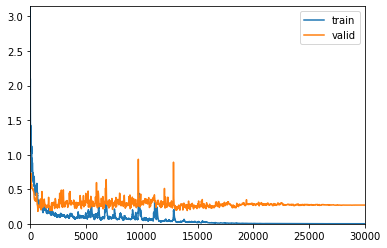

Better model found at epoch 2 with valid_loss value: 0.5103678107261658.
Better model found at epoch 6 with valid_loss value: 0.5066655874252319.
Better model found at epoch 7 with valid_loss value: 0.49165162444114685.
Better model found at epoch 9 with valid_loss value: 0.46341609954833984.
Better model found at epoch 10 with valid_loss value: 0.4574292004108429.
Better model found at epoch 11 with valid_loss value: 0.37336355447769165.
Better model found at epoch 12 with valid_loss value: 0.34927862882614136.
Better model found at epoch 14 with valid_loss value: 0.33066287636756897.
Better model found at epoch 16 with valid_loss value: 0.3277312219142914.
Better model found at epoch 20 with valid_loss value: 0.27315691113471985.
Better model found at epoch 21 with valid_loss value: 0.2644402086734772.
Better model found at epoch 22 with valid_loss value: 0.17988474667072296.


In [20]:
learn.fine_tune(1000,base_lr=1e-3)

In [21]:
learn.load('convnext_base_Volumen')

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [22]:
def is_test(f):
    return (df[df['image_id']=='datasetClean/'+f.name]['split']).values[0]=='test'

In [23]:
dbtest = DataBlock(blocks = (ImageBlock, RegressionBlock()),
                 get_items=get_image_files, 
                 splitter=FuncSplitter(is_test),
                 get_y=get_volumen,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=512,flip_vert=True,
                                            max_zoom=1.0), Normalize.from_stats(*imagenet_stats)])

In [24]:
dlstest = dbtest.dataloaders(path,bs=8)

In [25]:
learn.dls=dlstest

In [26]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.3812355697154999.


(#2) [0.36197376251220703,0.3812355697154999]

In [27]:
from sklearn.metrics import mean_absolute_error

In [28]:
preds,gt = learn.get_preds()

In [29]:
mean_absolute_error(gt,preds)

0.38123563

In [30]:
preds,gt = learn.tta()

In [31]:
mean_absolute_error(gt,preds)

0.40892276